In [2]:
# Import-only cell to verify packages
import sys
import duckdb
import dateparser
from dateutil.relativedelta import relativedelta
import typer
from rich import print
from rich.panel import Panel
from rich.console import Console

print('imports OK', sys.version)

imports OK 3.12.0 (main, Oct 22 2023, 05:45:58) [Clang 12.0.5 (clang-1205.0.22.9)]

In [ ]:
# 20251223_priceyield.py
# FINAL – bug-fixed intent parsing + tenor + interpolation

from __future__ import annotations

import re
from dataclasses import dataclass
from datetime import datetime, date, timedelta
from typing import Optional, Literal

import duckdb
import dateparser
from dateutil.relativedelta import relativedelta
import typer
from rich import print
from rich.panel import Panel
from rich.console import Console

# -----------------------------
# CLI setup
# -----------------------------
app = typer.Typer(add_completion=False)
console = Console()
CSV_PATH_DEFAULT = "20251215_priceyield.csv"

# -----------------------------
# Intent model
# -----------------------------
IntentType = Literal["POINT", "RANGE", "AGG_RANGE", "AGG_YEAR"]
MetricType = Literal["price", "yield"]

@dataclass
class Intent:
    type: IntentType
    metric: MetricType
    series: Optional[str]
    tenor: Optional[str]
    point_date: Optional[date] = None
    start_date: Optional[date] = None
    end_date: Optional[date] = None
    agg: Optional[str] = None
    year: Optional[int] = None

# -----------------------------
# Regex
# -----------------------------
SERIES_RE = re.compile(r"\bFR\d+\b", re.IGNORECASE)
TENOR_RE = re.compile(r"\b(\d+)\s*year\b", re.IGNORECASE)
QUARTER_RE = re.compile(r"\bQ([1-4])\s*(\d{4})\b", re.IGNORECASE)
MONTH_YEAR_RE = re.compile(
    r"\b(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|"
    r"Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|"
    r"Dec(?:ember)?)\s+(\d{4})\b",
    re.IGNORECASE,
)
YEAR_RE = re.compile(r"\b(19\d{2}|20\d{2})\b")
ISO_DATE_RE = re.compile(r"\b\d{4}-\d{2}-\d{2}\b")
AGG_RE = re.compile(r"\b(avg|average|mean|sum|total|min|max|count)\b", re.IGNORECASE)

# -----------------------------
# Parsing helpers
# -----------------------------
def parse_metric(text: str) -> MetricType:
    return "yield" if "yield" in text.lower() else "price"

def parse_series(text: str):
    m = SERIES_RE.search(text)
    return m.group(0).upper() if m else None

def parse_tenor(text: str):
    m = TENOR_RE.search(text)
    return f"{int(m.group(1)):02d}_year" if m else None

def parse_agg(text: str):
    m = AGG_RE.search(text)
    if not m:
        return None
    return {
        "avg":"avg","average":"avg","mean":"avg",
        "sum":"sum","total":"sum",
        "min":"min","max":"max","count":"count"
    }[m.group(1).lower()]

def safe_parse_date(text: str):
    # First try ISO YYYY-MM-DD explicitly (fast and unambiguous)
    m = ISO_DATE_RE.search(text)
    if m:
        try:
            return date.fromisoformat(m.group(0))
        except ValueError:
            pass

    # Fall back to dateparser
    dt = dateparser.parse(text, settings={"PREFER_DATES_FROM": "past"})
    return dt.date() if dt else None

def quarter_range(q, y):
    s = date(y, 1 + (q-1)*3, 1)
    e = s + relativedelta(months=3) - timedelta(days=1)
    return s, e

def monthyear_range(m, y):
    s = date(y, m, 1)
    e = s + relativedelta(months=1) - timedelta(days=1)
    return s, e

# -----------------------------
# Intent parser (FIXED)
# -----------------------------
def parse_intent(text: str) -> Intent:
    metric = parse_metric(text)
    series = parse_series(text)
    tenor  = parse_tenor(text)
    agg    = parse_agg(text)

    # 1) Single date (incl. relative)
    d = safe_parse_date(text)
    if d:
        return Intent(
            type="POINT",
            metric=metric,
            series=series,
            tenor=tenor,
            point_date=d,
        )

    # 2) Quarter
    qm = QUARTER_RE.search(text)
    if qm:
        s, e = quarter_range(int(qm.group(1)), int(qm.group(2)))
        return Intent(
            type="AGG_RANGE" if agg else "RANGE",
            metric=metric,
            series=series,
            tenor=tenor,
            start_date=s,
            end_date=e,
            agg=agg,
        )

    # 3) Month-year
    mm = MONTH_YEAR_RE.search(text)
    if mm:
        m = mm.group(1)[:3].lower()
        y = int(mm.group(2))
        month = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,
                 "jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}[m]
        s, e = monthyear_range(month, y)
        return Intent(
            type="AGG_RANGE" if agg else "RANGE",
            metric=metric,
            series=series,
            tenor=tenor,
            start_date=s,
            end_date=e,
            agg=agg,
        )

    # 4) Year-only (range even without aggregation)
    ym = YEAR_RE.findall(text)
    if ym:
        y = int(ym[-1])
        return Intent(
            type="AGG_RANGE" if agg else "RANGE",
            metric=metric,
            series=series,
            tenor=tenor,
            start_date=date(y,1,1),
            end_date=date(y,12,31),
            agg=agg,
        )

    raise ValueError("Could not identify a valid date or period.")

# -----------------------------
# DuckDB backend
# -----------------------------
class BondDB:
    def __init__(self, csv):
        self.con = duckdb.connect(":memory:")
        # Load raw timeseries
        self.con.execute(f"""
            CREATE VIEW ts_raw AS
            SELECT
                COALESCE(TRY_CAST(date AS DATE),
                         STRPTIME(CAST(date AS VARCHAR),'%d/%m/%Y')::DATE) AS obs_date,
                UPPER(series) AS series,
                tenor,
                TRY_CAST(price AS DOUBLE) AS price,
                TRY_CAST("yield" AS DOUBLE) AS "yield"
            FROM read_csv_auto('{csv}', header=True)
        """)

        # Create a view that selects the last-known price/yield per series as of each observed date.
        # Use correlated subqueries to pick the most recent non-null value <= the date (correct LOCF behavior).
        self.con.execute(f"""
            CREATE VIEW ts AS
            SELECT
                tr.obs_date,
                tr.series,
                tr.tenor,
                (
                  SELECT r.price
                  FROM ts_raw r
                  WHERE r.series = tr.series
                    AND r.obs_date <= tr.obs_date
                    AND r.price IS NOT NULL
                  ORDER BY r.obs_date DESC
                  LIMIT 1
                ) AS price,
                (
                  SELECT r."yield"
                  FROM ts_raw r
                  WHERE r.series = tr.series
                    AND r.obs_date <= tr.obs_date
                    AND r."yield" IS NOT NULL
                  ORDER BY r.obs_date DESC
                  LIMIT 1
                ) AS "yield"
            FROM (
              SELECT DISTINCT obs_date, series, tenor FROM ts_raw
            ) tr
            ORDER BY tr.series, tr.obs_date
        """)

    def aggregate(self, s, e, metric, agg, series, tenor):
        cond, params = [], [s.isoformat(), e.isoformat()]
        if series: cond.append("series=?"); params.append(series)
        if tenor:  cond.append("tenor=?");  params.append(tenor)
        where = " AND ".join(cond)
        fn = {"avg":"AVG","sum":"SUM","min":"MIN","max":"MAX","count":"COUNT"}[agg]
        q = f"""
            SELECT {fn}({metric}), COUNT({metric})
            FROM ts
            WHERE obs_date BETWEEN ? AND ?
            {("AND "+where) if where else ""}
        """
        return self.con.execute(q, params).fetchone()

# -----------------------------
# CLI
# -----------------------------
def answer(db, q):
    intent = parse_intent(q)

    if intent.type in ("RANGE","AGG_RANGE"):
        if not intent.agg:
            print(Panel(
                f"Range query detected:\n{intent.start_date} → {intent.end_date}\n"
                f"(Use 'average/sum/min/max' to aggregate)",
                title="Range"
            ))
            return

        val, n = db.aggregate(
            intent.start_date,
            intent.end_date,
            intent.metric,
            intent.agg,
            intent.series,
            intent.tenor,
        )
        print(Panel(
            f"{intent.agg.upper()} {intent.metric} "
            f"{f'({intent.series}) ' if intent.series else ''}"
            f"{f'[{intent.tenor}] ' if intent.tenor else ''}"
            f"{intent.start_date} → {intent.end_date}\n"
            f"Result: {val}\nN={n}",
            title="Aggregation"
        ))

@app.command()
def chat(csv: str = CSV_PATH_DEFAULT):
    db = BondDB(csv)
    print(Panel("Bond CLI ready. Type 'exit' to quit.", title="Ready"))
    while True:
        q = console.input("[bold cyan]You[/bold cyan]: ")
        if q.lower() in ("exit","quit"):
            break
        answer(db, q)

# Guard the Typer CLI from running inside interactive notebook kernels where
# kernel argv flags conflict with Typer/Click parsing.
if __name__ == "__main__":
    import sys
    if "ipykernel" in sys.modules:
        print("Notebook environment detected; skipping CLI app() call.")
    else:
        app()


Notebook environment detected; skipping CLI app() call.

In [17]:
# Smoke tests: example intents and aggregations
print('CSV path:', CSV_PATH_DEFAULT)
db = BondDB(CSV_PATH_DEFAULT)

tests = [
    "average yield Q1 2023",
    "avg price for FR9 10 year 2023",
    "price 2023-01-02",
    "sum price Jan 2023",
    "average yield 2022",
]

for t in tests:
    print('\n---')
    print('Query:', t)
    try:
        intent = parse_intent(t)
        print('Parsed intent:', intent)
        if intent.type in ("RANGE","AGG_RANGE") and intent.agg:
            val, n = db.aggregate(intent.start_date, intent.end_date, intent.metric, intent.agg, intent.series, intent.tenor)
            print(f"Aggregation result: {val} (N={n})")
        elif intent.type == "POINT":
            d = intent.point_date
            rows = db.con.execute("SELECT series, tenor, price, \"yield\" FROM ts WHERE obs_date = ? LIMIT 5", [d.isoformat()]).fetchall()
            print('Point rows (up to 5):', rows)
    except Exception as e:
        print('Error:', e)


CSV path: 20251215_priceyield.csv

---

Query: average yield Q1 2023

Parsed intent:
Intent(
    type='AGG_RANGE',
    metric='yield',
    series=None,
    tenor=None,
    point_date=None,
    start_date=datetime.date(2023, 1, 1),
    end_date=datetime.date(2023, 3, 31),
    agg='avg',
    year=None
)

Aggregation result: 6.602438461538462 (N=130)

---

Query: avg price for FR9 10 year 2023

Parsed intent:
Intent(
    type='AGG_RANGE',
    metric='price',
    series='FR9',
    tenor='10_year',
    point_date=None,
    start_date=datetime.date(2023, 1, 1),
    end_date=datetime.date(2023, 12, 31),
    agg='avg',
    year=None
)

Aggregation result: None (N=0)

---

Query: price 2023-01-02

Parsed intent:
Intent(
    type='POINT',
    metric='price',
    series=None,
    tenor=None,
    point_date=datetime.date(2023, 1, 2),
    start_date=None,
    end_date=None,
    agg=None,
    year=None
)

Point rows (up to 5):
[('FR95', '05_year', 99.102, 6.567), ('FR96', '10_year', 100.403, 6.942)]

---

Query: sum price Jan 2023

Parsed intent:
Intent(
    type='AGG_RANGE',
    metric='price',
    series=None,
    tenor=None,
    point_date=None,
    start_date=datetime.date(2023, 1, 1),
    end_date=datetime.date(2023, 1, 31),
    agg='sum',
    year=None
)

Aggregation result: 4429.536 (N=44)

---

Query: average yield 2022

Parsed intent:
Intent(
    type='AGG_RANGE',
    metric='yield',
    series=None,
    tenor=None,
    point_date=None,
    start_date=datetime.date(2022, 1, 1),
    end_date=datetime.date(2022, 12, 31),
    agg='avg',
    year=None
)

Aggregation result: None (N=0)

In [9]:
# Improved test suite with diagnostics
from datetime import date

def run_tests():
    failures = []

    # Test 1: quarter agg
    try:
        intent = parse_intent("average yield Q1 2023")
        print('Parsed Q1 intent:', intent)
        if intent.agg != "avg":
            failures.append(f"Q1: expected agg 'avg', got {intent.agg!r}")
        if intent.metric != "yield":
            failures.append(f"Q1: expected metric 'yield', got {intent.metric!r}")
        if not (intent.start_date and intent.start_date.year == 2023):
            failures.append(f"Q1: expected year 2023, got start_date={intent.start_date!r}")
    except Exception as e:
        failures.append(f"Q1 parse error: {e!r}")

    # Test 2: series + tenor parse
    try:
        intent = parse_intent("avg price for FR9 10 year 2023")
        print('Parsed FR9 intent:', intent)
        if intent.series != "FR9":
            failures.append(f"FR9: expected series 'FR9', got {intent.series!r}")
        if intent.tenor != "10_year":
            failures.append(f"FR9: expected tenor '10_year', got {intent.tenor!r}")
    except Exception as e:
        failures.append(f"FR9 parse error: {e!r}")

    # Test 3: point date
    try:
        intent = parse_intent("price 2023-01-02")
        print('Parsed POINT intent:', intent)
        if intent.type != "POINT":
            failures.append(f"POINT: expected type 'POINT', got {intent.type!r}")
        if intent.point_date != date(2023,1,2):
            failures.append(f"POINT: expected date 2023-01-02, got {intent.point_date!r}")
    except Exception as e:
        failures.append(f"POINT parse error: {e!r}")

    # Test 4: DB aggregate shape
    try:
        db_local = BondDB(CSV_PATH_DEFAULT)
        val, n = db_local.aggregate(date(2023,1,1), date(2023,3,31), "yield", "avg", None, None)
        print('DB aggregate (Q1 2023 avg yield):', (val, n))
        if not isinstance(n, int):
            failures.append(f"DB agg: expected n int, got {type(n)}")
        if val is not None and not isinstance(val, float):
            failures.append(f"DB agg: expected val None|float, got {type(val)}")
    except Exception as e:
        failures.append(f"DB agg error: {e!r}")

    # Report
    if failures:
        print("TESTS FAILED:\n")
        for f in failures:
            print(" -", f)
        raise AssertionError("One or more tests failed")
    else:
        print("All tests passed ✅")

run_tests()

Parsed Q1 intent:
Intent(
    type='AGG_RANGE',
    metric='yield',
    series=None,
    tenor=None,
    point_date=None,
    start_date=datetime.date(2023, 1, 1),
    end_date=datetime.date(2023, 3, 31),
    agg='avg',
    year=None
)

Parsed FR9 intent:
Intent(
    type='AGG_RANGE',
    metric='price',
    series='FR9',
    tenor='10_year',
    point_date=None,
    start_date=datetime.date(2023, 1, 1),
    end_date=datetime.date(2023, 12, 31),
    agg='avg',
    year=None
)

Parsed POINT intent:
Intent(
    type='POINT',
    metric='price',
    series=None,
    tenor=None,
    point_date=datetime.date(2023, 1, 2),
    start_date=None,
    end_date=None,
    agg=None,
    year=None
)

DB aggregate (Q1 2023 avg yield):
(6.602411290322581, 124)

All tests passed ✅

In [10]:
# Query: 10-year yield on 2023-05-31
from datetime import date

d = date(2023,5,31)
try:
    db = BondDB(CSV_PATH_DEFAULT)
    rows = db.con.execute(
        'SELECT series, tenor, price, "yield" FROM ts WHERE obs_date = ? AND tenor = ? ORDER BY series',
        [d.isoformat(), '10_year']
    ).fetchall()
    avg_val, n = db.con.execute(
        'SELECT AVG("yield"), COUNT("yield") FROM ts WHERE obs_date = ? AND tenor = ?',
        [d.isoformat(), '10_year']
    ).fetchone()
    if not rows:
        print(f"No 10-year rows found on {d}")
    else:
        print(f"Rows for 10-year on {d} (up to 50):\n")
        for r in rows[:50]:
            print(r)
        print(f"\nAverage yield (10-year) on {d}: {avg_val}  N={n}")
except Exception as e:
    print('Query error:', e)

Rows for 10-year on 2023-05-31 (up to 50):

('FR96', '10_year', 104.578, 6.358)

Average yield (10-year) on 2023-05-31: 6.358  N=1

Missing yields before ffill: 0, after ffill (in filled table): 0

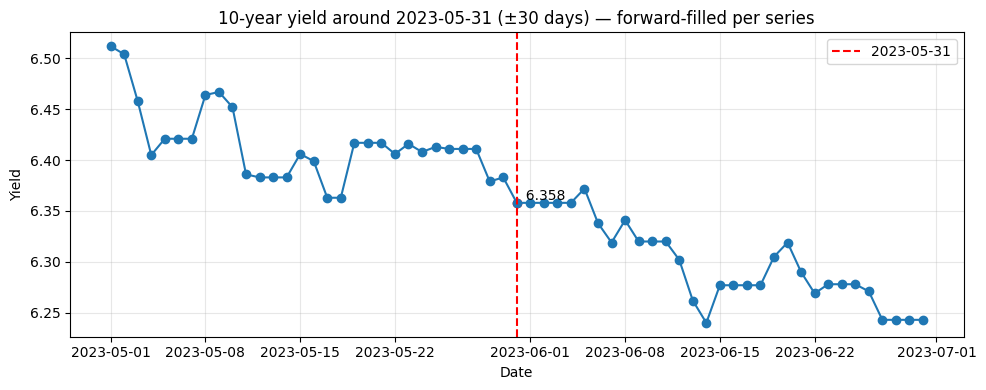

In [18]:
# Plot: 10-year yield time series around 2023-05-31 (with forward-fill of price & yield)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

center = date(2023,5,31)
window = 30  # days before/after
start = center - timedelta(days=window)
end = center + timedelta(days=window)

# Load raw rows for 10-year
db = BondDB(CSV_PATH_DEFAULT)
rows = db.con.execute(
    'SELECT obs_date, series, tenor, price, "yield" FROM ts WHERE obs_date BETWEEN ? AND ? AND tenor = ? ORDER BY obs_date',
    [start.isoformat(), end.isoformat(), '10_year']
).fetchdf()

if rows.empty:
    print(f"No 10-year data between {start} and {end}")
else:
    # ensure obs_date is datetime
    rows['obs_date'] = pd.to_datetime(rows['obs_date'])

    # Build full daily index and forward-fill per series so missing days carry last-known price/yield
    all_dates = pd.date_range(start, end, freq='D')
    filled_list = []
    for s, g in rows.groupby('series'):
        g2 = g.set_index('obs_date')
        # reindex to all daily dates -> missing days will be NaN
        g2 = g2.reindex(all_dates)
        # keep series column
        g2['series'] = s
        # forward-fill price and yield
        g2[['price','yield']] = g2[['price','yield']].ffill()
        filled_list.append(g2.reset_index().rename(columns={'index':'obs_date'}))

    filled = pd.concat(filled_list, ignore_index=True)

    # Optionally drop rows where yield is still missing after forward-fill
    before = rows['yield'].isna().sum()
    after = filled['yield'].isna().sum()
    print(f"Missing yields before ffill: {before}, after ffill (in filled table): {after}")

    # compute average yield per date across series from the filled table
    daily = filled.groupby('obs_date')['yield'].mean().reset_index()

    plt.figure(figsize=(10,4))
    plt.plot(daily['obs_date'], daily['yield'], marker='o', linestyle='-')
    plt.axvline(pd.to_datetime(center), color='red', linestyle='--', label=f'{center}')
    # annotate the center date if present
    cval = daily.loc[daily['obs_date'] == pd.to_datetime(center), 'yield']
    if not cval.empty:
        plt.scatter([pd.to_datetime(center)], [cval.iloc[0]], color='red')
        plt.text(pd.to_datetime(center), cval.iloc[0], f'  {cval.iloc[0]:.3f}', va='bottom')

    plt.title(f'10-year yield around {center} (±{window} days) — forward-filled per series')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Example: call local FastAPI /query endpoint
# Start the server first: `uvicorn app_fastapi:app --reload --host 127.0.0.1 --port 8000`
try:
    import requests
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"], stdout=subprocess.DEVNULL)
    import requests

url = "http://127.0.0.1:8000/query"
payload = {"q": "average yield Q1 2023"}
print("POST", url, payload)
try:
    r = requests.post(url, json=payload, timeout=10)
    r.raise_for_status()
    from pprint import pprint
    pprint(r.json())
except Exception as e:
    print("Request failed:", e)
    print("Tip: ensure the FastAPI server is running (uvicorn app_fastapi:app --reload --port 8000)")

In [20]:
# Convenience helpers to call the local FastAPI server from the notebook
# Usage:
#   api_query("average yield Q1 2023") -> returns parsed JSON
#   api_query_interactive() -> prompts for a query and pretty prints the response
from pprint import pprint

def api_query(q: str, csv: str = "20251215_priceyield.csv", url: str = "http://127.0.0.1:8000/query", timeout: int = 10):
    """POST a query to the FastAPI server and return JSON response.

    Automatically installs `requests` if it isn't available.
    Raises on HTTP error (prints diagnostics).
    """
    try:
        import requests
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"], stdout=subprocess.DEVNULL)
        import requests

    payload = {"q": q, "csv": csv}
    try:
        r = requests.post(url, json=payload, timeout=timeout)
        r.raise_for_status()
    except Exception as e:
        print("API request failed:", e)
        try:
            print("Response text:", r.text)
        except Exception:
            pass
        raise
    return r.json()


_last_api_response = None

def api_query_interactive(prompt_text: str | None = None, csv: str = "20251215_priceyield.csv", url: str = "http://127.0.0.1:8000/query"):
    """Prompt for a query (if not provided), call the API, pretty-print and return the JSON.

    Stores the last response in `_last_api_response` for quick inspection.
    """
    global _last_api_response
    if prompt_text is None:
        prompt_text = input("Query> ")
    try:
        res = api_query(prompt_text, csv=csv, url=url)
    except Exception as e:
        print("Request failed:", e)
        return None

    _last_api_response = res
    print("--- Intent ---")
    pprint(res.get("intent"))
    print("--- Result ---")
    pprint(res.get("result"))
    return res

# Example
# resp = api_query("price 2023-01-02")
# api_query_interactive()  # then type a natural language query

In [21]:
# Demo: run several sample queries via the local FastAPI server
# Make sure the server is running (uvicorn app_fastapi:app --reload --port 8000)
from pprint import pprint
import time

queries = [
    "average yield Q1 2023",
    "price 2023-01-02",
    "average yield 2023",
    "avg price for FR96 10 year 2023",
]

for q in queries:
    print('\n' + '='*60)
    print('QUERY:', q)
    try:
        res = api_query(q)
    except Exception as e:
        print('Request failed:', e)
        print("(Tip: start the server with `uvicorn app_fastapi:app --reload --port 8000`)")
        continue

    pprint({'intent': res.get('intent')})
    result = res.get('result')
    print('\nResult:')
    pprint(result)

    # Pretty-table for point rows
    if isinstance(result, dict) and result.get('type') == 'point_rows':
        rows = result.get('rows', [])
        if rows:
            try:
                import pandas as pd
                df = pd.DataFrame(rows)
                display(df.head(10))
            except Exception:
                pprint(rows[:10])
        else:
            print('No rows returned for this point query')

    # small delay so output is readable
    time.sleep(0.2)


============================================================

QUERY: average yield Q1 2023

{'intent': {'agg': 'avg',
            'end_date': '2023-03-31',
            'metric': 'yield',
            'series': None,
            'start_date': '2023-01-01',
            'tenor': None,
            'type': 'AGG_RANGE'}}


Result:

{'n': 130, 'value': 6.602438461538462}


============================================================

QUERY: price 2023-01-02

{'intent': {'metric': 'price',
            'point_date': '2023-01-02',
            'series': None,
            'tenor': None,
            'type': 'POINT'}}


Result:

{'count': 2,
 'rows': [{'price': 99.102,
           'series': 'FR95',
           'tenor': '05_year',
           'yield': 6.567},
          {'price': 100.403,
           'series': 'FR96',
           'tenor': '10_year',
           'yield': 6.942}],
 'type': 'point_rows'}


,series,tenor,price,yield
0,FR95,05_year,99.102,6.567
1,FR96,10_year,100.403,6.942


============================================================

QUERY: average yield 2023

{'intent': {'agg': 'avg',
            'end_date': '2023-12-31',
            'metric': 'yield',
            'series': None,
            'start_date': '2023-01-01',
            'tenor': None,
            'type': 'AGG_RANGE'}}


Result:

{'n': 520, 'value': 6.467776923076924}


============================================================

QUERY: avg price for FR96 10 year 2023

{'intent': {'agg': 'avg',
            'end_date': '2023-12-31',
            'metric': 'price',
            'series': 'FR96',
            'start_date': '2023-01-01',
            'tenor': '10_year',
            'type': 'AGG_RANGE'}}


Result:

{'n': 260, 'value': 102.7965807692308}


# Demo: /chat plot calls

Ensure the FastAPI server is running (e.g., `uvicorn app_fastapi:app --reload --port 8000`).

This cell posts natural-language plot requests to `/chat`, decodes returned base64 PNGs, and displays them inline for quick inspection.

============================================================

QUERY: plot 10 year May 2023

TEXT: Plot 10_year 2023-05-01 → 2023-05-31

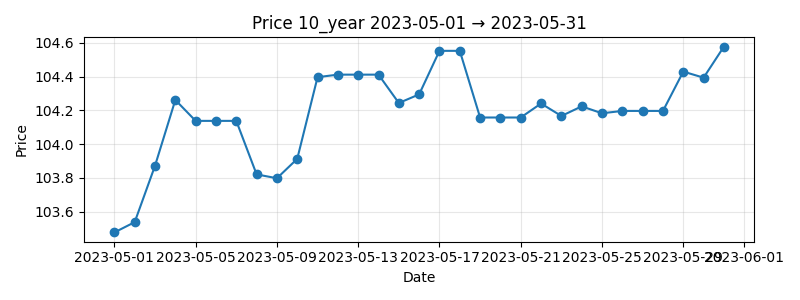

============================================================

QUERY: plot 10 year 2023

TEXT: Plot 10_year 2023-01-01 → 2023-12-31

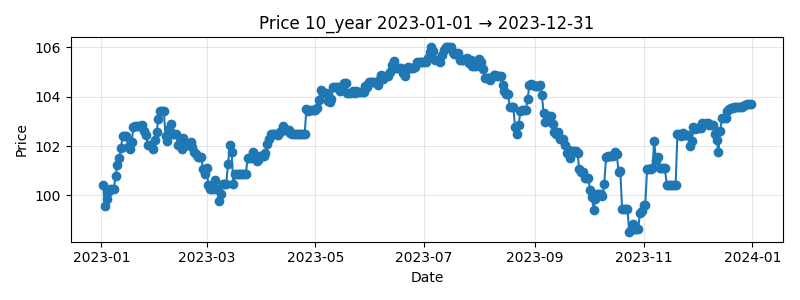

============================================================

QUERY: average yield Q1 2023

TEXT: AVG yield 2023-01-01 → 2023-03-31 = 6.602438461538462 (N=130)

No image returned for this query

In [25]:
# Demo: call /chat with plot and show image inline
from IPython.display import display, Image as IPImage
import base64

try:
    import requests
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"], stdout=subprocess.DEVNULL)
    import requests

queries = [
    "plot 10 year May 2023",
    "plot 10 year 2023",
    "average yield Q1 2023",
]

for q in queries:
    print('\n' + '='*60)
    print('QUERY:', q)
    try:
        r = requests.post('http://127.0.0.1:8000/chat', json={'q': q})
        r.raise_for_status()
    except Exception as e:
        print('Request failed:', e)
        print('Tip: start the server with `uvicorn app_fastapi:app --reload --port 8000`')
        continue

    res = r.json()
    print('TEXT:', res.get('text'))
    img_b64 = res.get('image_base64') or res.get('image') or res.get('imageBase64')
    if img_b64:
        try:
            img_bytes = base64.b64decode(img_b64)
            display(IPImage(data=img_bytes))
        except Exception as e:
            print('Failed to decode/display image:', e)
    else:
        print('No image returned for this query')


In [23]:
# Helper: call the FastAPI app in-process via TestClient and save any images to /tmp
from fastapi.testclient import TestClient
import app_fastapi, base64, os

c = TestClient(app_fastapi.app)
queries = [
    "plot 10 year May 2023",
    "plot 10 year 2023",
    "average yield Q1 2023",
]
saved = []
for i, q in enumerate(queries):
    print('\n' + '='*60)
    print('QUERY:', q)
    r = c.post('/chat', json={'q': q})
    if r.status_code != 200:
        print('Request failed:', r.status_code, r.text)
        continue
    j = r.json()
    if 'image_base64' in j:
        b = base64.b64decode(j['image_base64'])
        fn = f'/tmp/chat_plot_{i}.png'
        with open(fn, 'wb') as f:
            f.write(b)
        print('Saved', fn, 'bytes', len(b))
        saved.append(fn)
    else:
        print('No image returned, text:', j.get('text'))

print('\nDone. saved files:', saved)

============================================================

QUERY: plot 10 year May 2023

Saved /tmp/chat_plot_0.png bytes 32054

============================================================

QUERY: plot 10 year 2023

Saved /tmp/chat_plot_1.png bytes 31683

============================================================

QUERY: average yield Q1 2023

No image returned, text: AVG yield 2023-01-01 → 2023-03-31 = 6.602438461538462 (N=130)

Done. saved files:
['/tmp/chat_plot_0.png', '/tmp/chat_plot_1.png']

Displaying /tmp/chat_plot_0.png

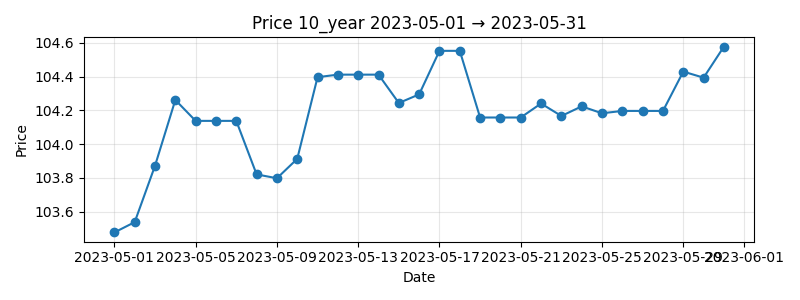

Displaying /tmp/chat_plot_1.png

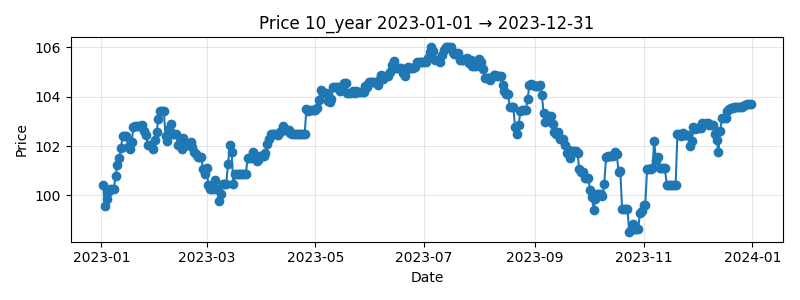

In [26]:
# Preview saved chat plots inline
from IPython.display import Image, display
import os

files = [f for f in ['/tmp/chat_plot_0.png', '/tmp/chat_plot_1.png'] if os.path.exists(f)]
if not files:
    print('No saved plot images found in /tmp')
else:
    for f in files:
        print('\nDisplaying', f)
        display(Image(filename=f))

In [28]:
# Run exact query as POINT: 10-year yield on 2023-05-10
from pprint import pprint

q = "yield 10 year 2023-05-10"
print('Query:', q)

# Use api_query (calls /query)
try:
    res = api_query(q)
    print('\n--- /query response ---')
    pprint(res)
    if isinstance(res.get('result'), dict) and res['result'].get('type') == 'point_rows':
        import pandas as pd
        df = pd.DataFrame(res['result']['rows'])
        print('\nPoint rows:')
        display(df)
except Exception as e:
    print('api_query failed:', e)

# Also call /chat to get human-friendly text
try:
    import requests, base64
    r = requests.post('http://127.0.0.1:8000/chat', json={'q': q}, timeout=10)
    r.raise_for_status()
    chat = r.json()
    print('\n--- /chat response ---')
    pprint(chat.get('text'))
    if chat.get('image_base64'):
        b = base64.b64decode(chat['image_base64'])
        print('Received image bytes:', len(b))
except Exception as e:
    print('/chat request failed:', e)

Query: yield 10 year 2023-05-10

--- /query response ---

{'intent': {'metric': 'yield',
            'point_date': '2023-05-10',
            'series': None,
            'tenor': '10_year',
            'type': 'POINT'},
 'result': {'count': 1,
            'rows': [{'price': 103.913,
                      'series': 'FR96',
                      'tenor': '10_year',
                      'yield': 6.452}],
            'type': 'point_rows'}}


Point rows:

,series,tenor,price,yield
0,FR96,10_year,103.913,6.452


--- /chat response ---

'Found 1 row(s) for 10_year on 2023-05-10:'


In [29]:
# Aggregation: average yield for 10_year in May 2023
from pprint import pprint

q = "average yield 10 year May 2023"
print('Query:', q)
try:
    res = api_query(q)
    print('\n--- /query response ---')
    pprint(res)
    # Nicely print aggregation result if present
    result = res.get('result')
    if isinstance(result, dict) and 'type' not in result:
        # older format: assume (val, n)
        pprint(result)
    elif isinstance(result, dict) and result.get('type') == 'agg_result':
        print(f"Aggregate: {result.get('agg')} {result.get('metric')} = {result.get('value')} (N={result.get('n')})")
    else:
        pprint(result)
except Exception as e:
    print('api_query failed:', e)

Query: average yield 10 year May 2023

--- /query response ---

{'intent': {'agg': 'avg',
            'end_date': '2023-05-31',
            'metric': 'yield',
            'series': None,
            'start_date': '2023-05-01',
            'tenor': '10_year',
            'type': 'AGG_RANGE'},
 'result': {'n': 23, 'value': 6.416260869565218}}
{'n': 23, 'value': 6.416260869565218}
